C:\Users\91908\AppData\Local\Temp\ipykernel_35008\3417082560.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


+----+------------------------+----------------------------------------------------------------------------------------------------------------+-------+------------+------------+--------------+-----------+
|    |         Scrip          |                                               Paragraph_content                                                | Score | Confidence |    Date    | FinBertScore | Strength  |
+----+------------------------+----------------------------------------------------------------------------------------------------------------+-------+------------+------------+--------------+-----------+
| 61 |  Action Construction   | Action Construction Equipment December 2023 (Quarterly) Income at Rs 753 crore vs Rs 556 crore YoY. PAT at Rs  |   1   |  0.51902   | 2024-02-07 |      0       |           |
|    |                        |                                          88 crore vs Rs 47 crore YoY                                           |       |            |           

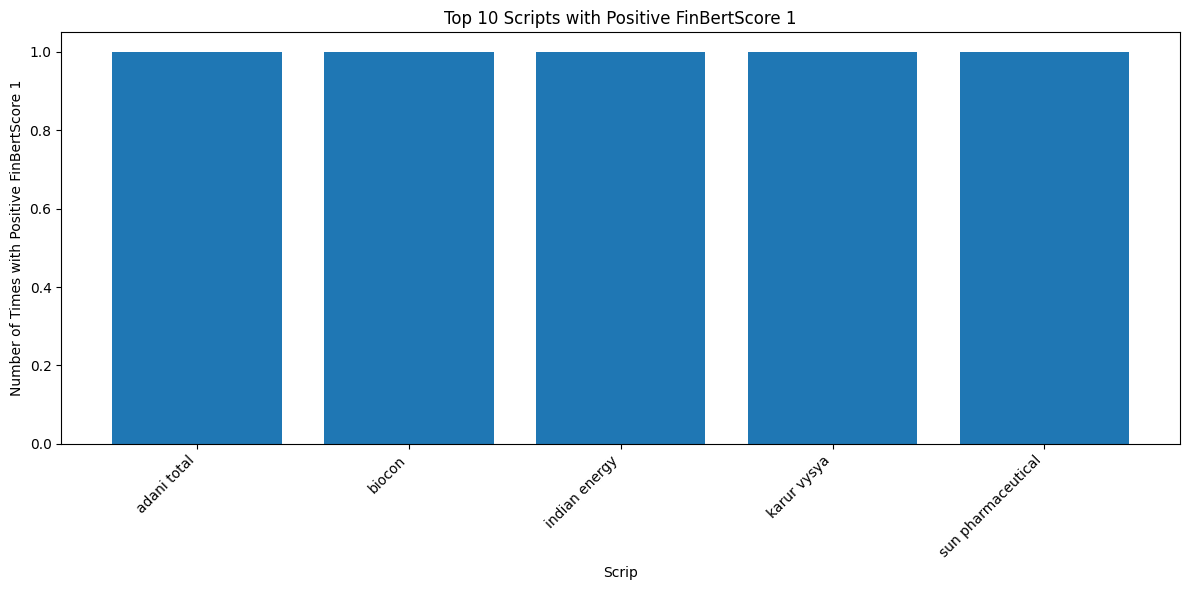

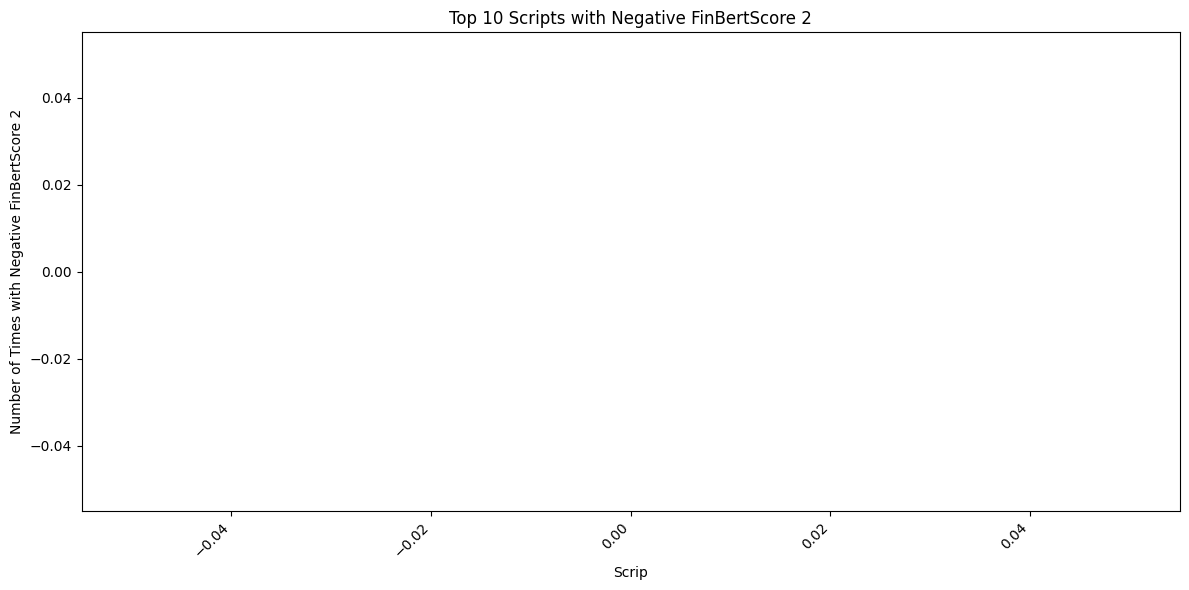

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import textwrap
from pymongo import MongoClient
from tabulate import tabulate
import matplotlib.pyplot as plt
import re
from datetime import datetime


# MongoDB connection URI (replace with your actual URI)
uri = "mongodb://localhost:27017"

# Specify the database and collection
database_name = "NewsAnalytics"
#collection_name = "RawNews_Hindu"
collection_name = "RawNews_StockEdge"

# Path to the Excel file
excel_file_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip01022024.xlsx'


try:
    # Create a new client and connect to the MongoDB server
    with MongoClient(uri) as client:
        
        collection = client[database_name][collection_name]
    
        # Query all records in the collection
        # all_records = collection.find()
    
        start_date = datetime(2024, 2, 7, 0, 0, 0)
        end_date = datetime(2024, 2, 8, 0, 0, 0)
        
    
        find_query = {
            "created_at": {
                "$gte": start_date,
                "$lt": end_date
            }
        }
    
        all_records = collection.find(find_query)
        mongo_documents = list(all_records)

        if not mongo_documents:
            print("No records found from DB")
        else:
    
            # Read the "Portfolio" sheet from the Excel file
            portfolio_df = pd.read_excel(excel_file_path, sheet_name='Top1000NSE', header=0)
    
            # Assuming the column containing stock names is named "Portfolio"
            stock_names_in_portfolio = portfolio_df['Top1000NSE'].tolist()
    
            # Create a list to store tuples of (Scrip, paragraph_content, label, confidence, date, strength)
            result_list = []
    
            # Check if each stock name in the portfolio is present in MongoDB documents
            for document in mongo_documents:
                for stock_name in stock_names_in_portfolio:
                    if stock_name.lower() in document['paragraph_content'].lower():
                        # Wrap paragraph content to a maximum of five words per line
                        wrapped_content = '\n'.join(textwrap.wrap(document['paragraph_content'], width=110))
                        
                        # Extract the numeric part from the 'Score' column
                        numeric_score = int(''.join(filter(str.isdigit, document['sentiment']['label'])))
                        
                        result_list.append((
                            stock_name,
                            wrapped_content,
                            numeric_score,  # Use the extracted numeric score
                            document['sentiment']['confidence'],
                            document['created_at'].strftime('%Y-%m-%d'),  # Extract date from created_at
                            document['FinBertScore'],
                            None  # Placeholder for Strength column
                        ))
                        break  # Break if at least one match is found for the current document
    
            # Create a DataFrame from the result list
            result_df = pd.DataFrame(result_list, columns=['Scrip', 'Paragraph_content', 'Score', 'Confidence', 'Date', 'FinBertScore', 'Strength'])
    
            # Check if Positive/Negative sheet is present in the Excel file
            xls = pd.ExcelFile(excel_file_path, engine='openpyxl')  # Use openpyxl engine
            if 'PositiveNegative' in xls.sheet_names:
                # Read the Positive/Negative sheet from the Excel file
                positive_negative_df = pd.read_excel(xls, sheet_name='PositiveNegative', header=0)
    
                # Assuming the column containing positive/negative words is named "PositiveNegative"
                positive_negative_words = positive_negative_df['PositiveNegative'].tolist()
    
                # Update the Strength column based on positive/negative words
                result_df['Strength'] = result_df.apply(
                    lambda row: ', '.join(
                        positive_negative_word
                        for positive_negative_word in positive_negative_words
                        if positive_negative_word.lower() in row['Paragraph_content'].lower()
                    ),
                    axis=1
                )
                
                # Wrap the entire 'Strength' column to a maximum width of 140 characters
            result_df['Strength'] = result_df['Strength'].apply(lambda x: '\n'.join(textwrap.wrap(str(x), width=17)))
    
            # Sort the DataFrame based on multiple columns in ascending order
            result_df['Confidence'] = result_df['Confidence'].apply(lambda x: f"{x:.5f}")
            result_df = result_df.sort_values(by=['Date', 'Scrip', 'Score', 'Confidence'], ascending=[False, True, False, False])
    
            # Display the DataFrame
            print(tabulate(result_df, headers='keys', tablefmt='pretty'))
    
    
    
            # Assuming 'result_df' is your DataFrame
            
            # Convert 'Scrip' to lowercase and trim spaces
            result_df['Scrip'] = result_df['Scrip'].str.lower().str.strip()
            
            # Calculate the counts of positive FinBertScores for each 'Scrip'
            positive_counts_1 = result_df[result_df['FinBertScore'] == 1].groupby('Scrip').size()
            
            # Select the top 10 results for FinBertScore 1
            top_10_results_1 = positive_counts_1.nlargest(50)
            
            # Set a larger figure size
            plt.figure(figsize=(12, 6))
            
            # Plot the results for FinBertScore 1
            plt.bar(top_10_results_1.index, top_10_results_1)
            plt.xlabel('Scrip')
            plt.ylabel('Number of Times with Positive FinBertScore 1')
            plt.title('Top 10 Scripts with Positive FinBertScore 1')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    
            
            # Calculate the counts of positive FinBertScores for each 'Scrip'
            positive_counts_2 = result_df[result_df['FinBertScore'] == 2].groupby('Scrip').size()
            
            # Select the top 10 results for FinBertScore 1
            top_10_results_2 = positive_counts_2.nlargest(50)
           
            # Set a larger figure size
            plt.figure(figsize=(12, 6))
            
            # Plot the results for FinBertScore 1
            plt.bar(top_10_results_2.index, top_10_results_2)
            plt.xlabel('Scrip')
            plt.ylabel('Number of Times with Negative FinBertScore 2')
            plt.title('Top 10 Scripts with Negative FinBertScore 2')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    
    

except Exception as e:
    print(e)
